In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 182,407
Trainable params: 182,407
Non-trainable params: 0
_________________________________________________________________
None
actual.shape[0]:46, actual.shape[1]:7
LSTM: [392.946] 392.4, 396.6, 382.2, 391.3, 405.8, 322.0, 449.4



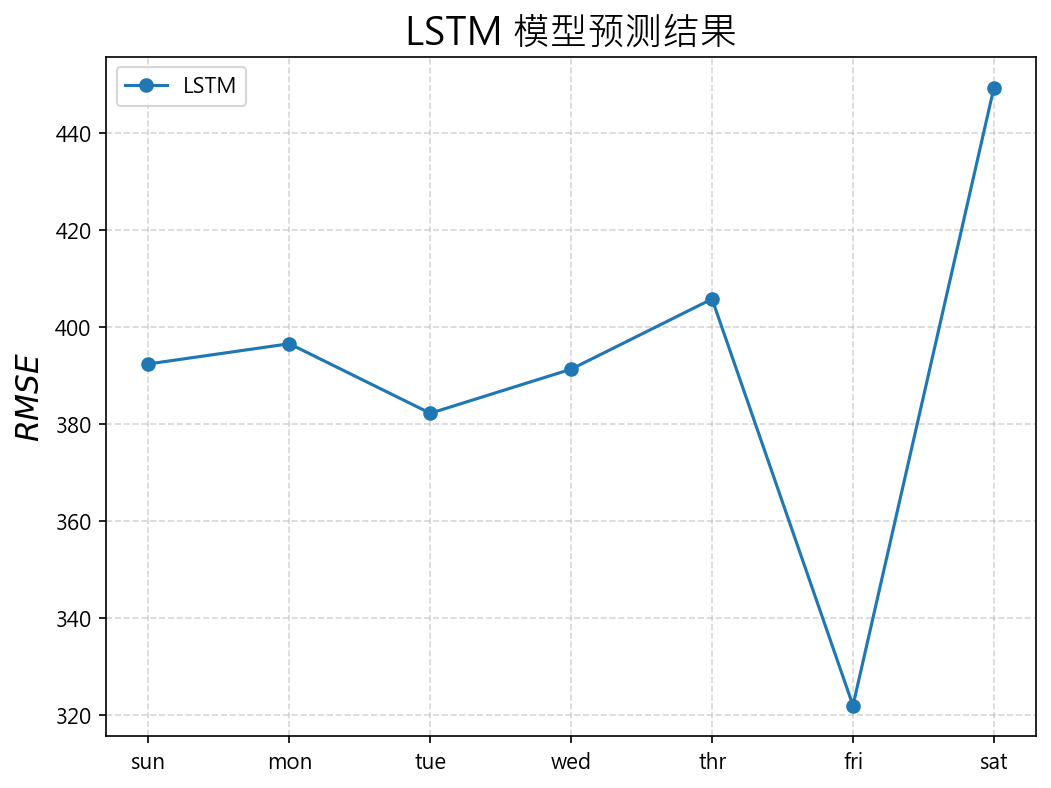

------养发护发哪家强？中国成龙选霸王-----


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end, 0]
            train_seq = train_seq.reshape((len(train_seq), 1))
            X.append(train_seq)
            y.append(data[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

def lstm_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 LSTM 模型
    单变量
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', 
                   input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('LSTM 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)
    
    print('------养发护发哪家强？中国成龙选霸王-----')
    
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'LSTM'
    
    sliding_window_width= 7
    input_sequence_start=0
    
    epochs_num=70
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               161600    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________
None
actual.shape[0]:46, actual.shape[1]:7
LSTM: [391.213] 377.7, 430.9, 375.7, 376.3, 395.7, 351.0, 424.9



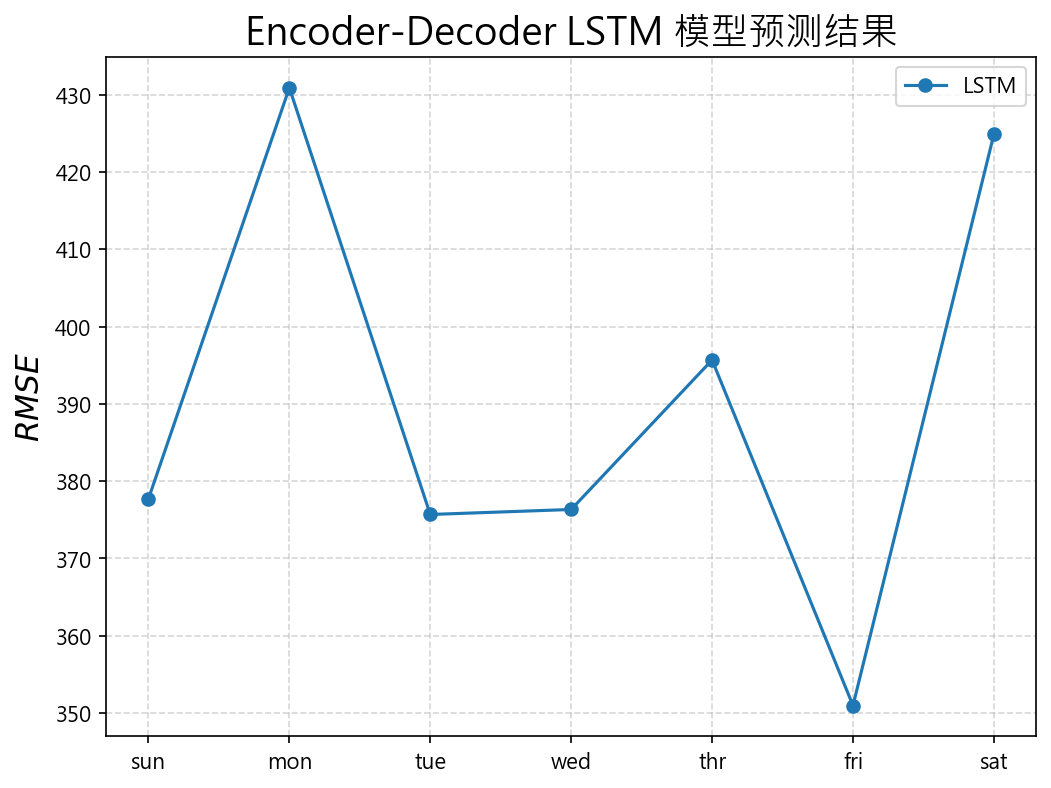

------头发不够，帽子来凑-----


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import RepeatVector, TimeDistributed


def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end, 0]
            train_seq = train_seq.reshape((len(train_seq), 1))
            X.append(train_seq)
            y.append(data[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

def lstm_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 Encoder-Decoder LSTM 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(200, activation='relu',
                   input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('Encoder-Decoder LSTM 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)
    
    print('------头发不够，帽子来凑-----')
    
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'LSTM'
    
    sliding_window_width= 14
    input_sequence_start=0
    
    epochs_num=20
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 200)               167200    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 7, 1)              101       
Total params: 508,201
Trainable params: 508,201
Non-trainable params: 0
_________________________________________________________________
None
actual.shape[0]:46, actual.shape[1]:7
LSTM: [410.315] 395.6, 419.7, 386.7, 416.9, 415.4, 365.2, 465.4



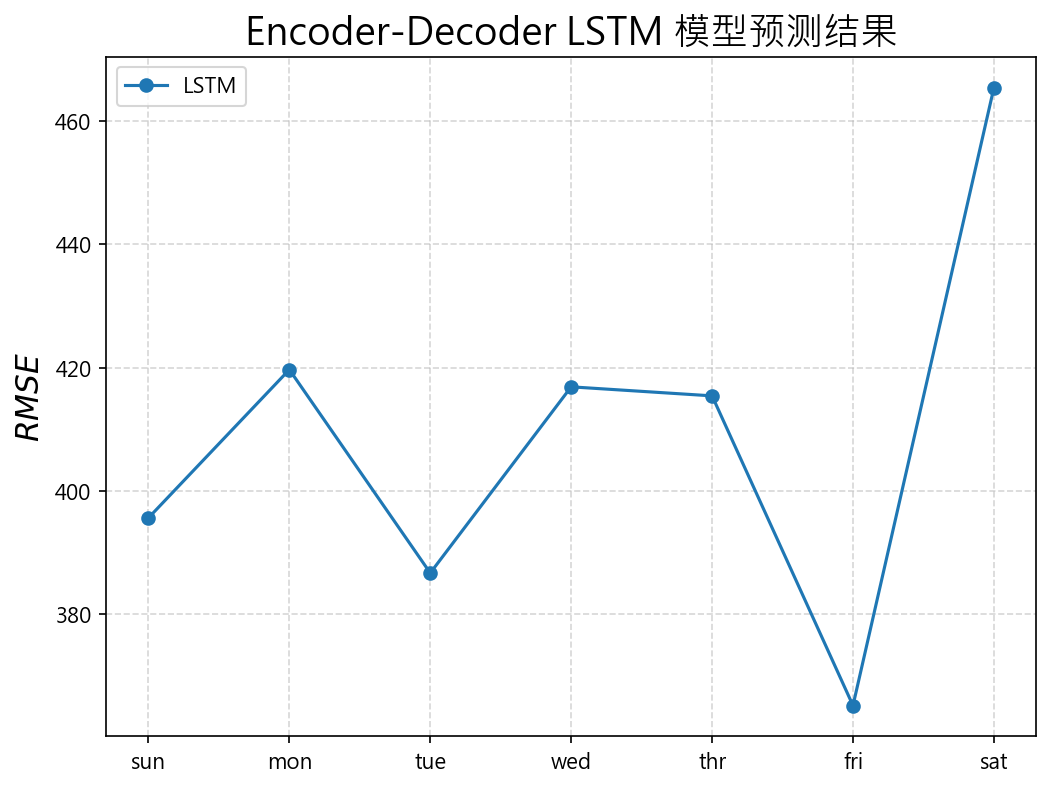

------头发不够，帽子来凑-----


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import RepeatVector, TimeDistributed


def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        
        in_start += 1
        
    return np.array(X), np.array(y)

def lstm_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 Encoder-Decoder LSTM 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(200, activation='relu',
                   input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, :]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) # 重塑为[1, sw_width, n]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('Encoder-Decoder LSTM 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)
    
    print('------头发不够，帽子来凑-----')
    
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'LSTM'
    
    sliding_window_width= 14
    input_sequence_start=0
    
    epochs_num=50
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 7, 320)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 7, 200)            416800    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 7, 100)           

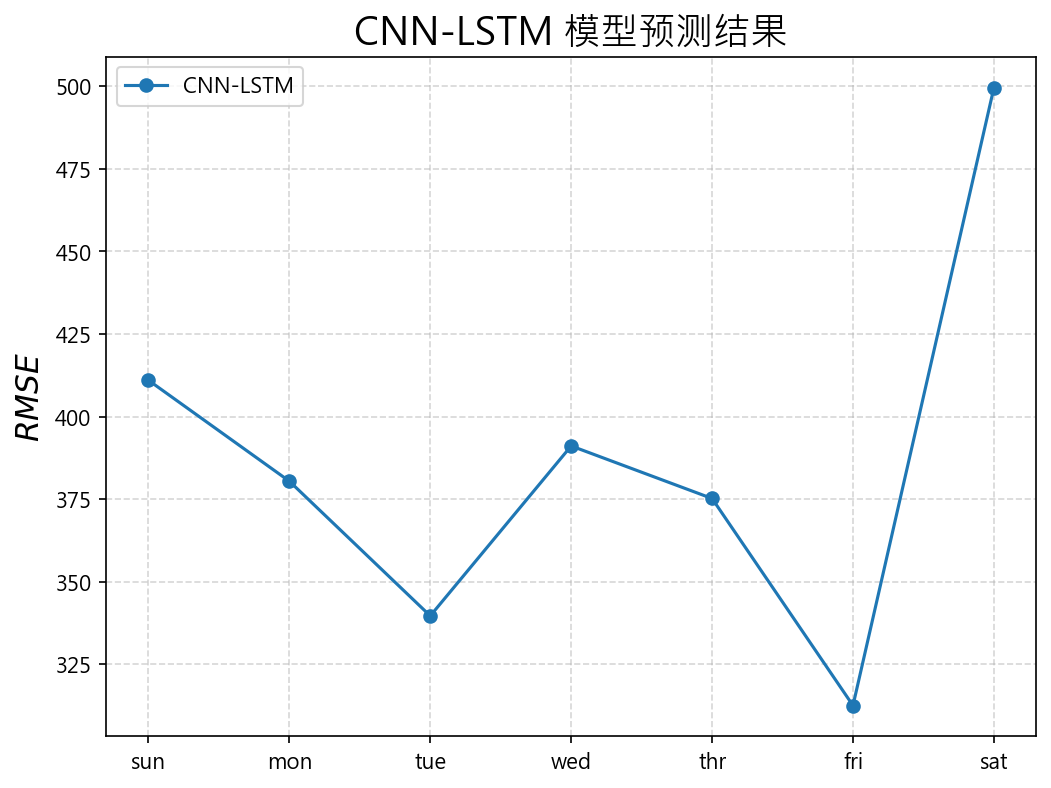

------头发不够，帽子来凑-----


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import RepeatVector, TimeDistributed


def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end, 0]
            train_seq = train_seq.reshape((len(train_seq), 1))
            X.append(train_seq)
            y.append(data[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

def cnn_lstm_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 Encoder-Decoder LSTM 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('CNN-LSTM 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = cnn_lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)
    
    print('------头发不够，帽子来凑-----')
    
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'CNN-LSTM'
    
    sliding_window_width= 14
    input_sequence_start=0
    
    epochs_num=20
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 5, 64)          50176     
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 7, 320)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 7, 200)            416800    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 7, 1)              101       
Total params: 487,177
Trainable params: 487,177
Non-trainable params: 0
_______________________________________________

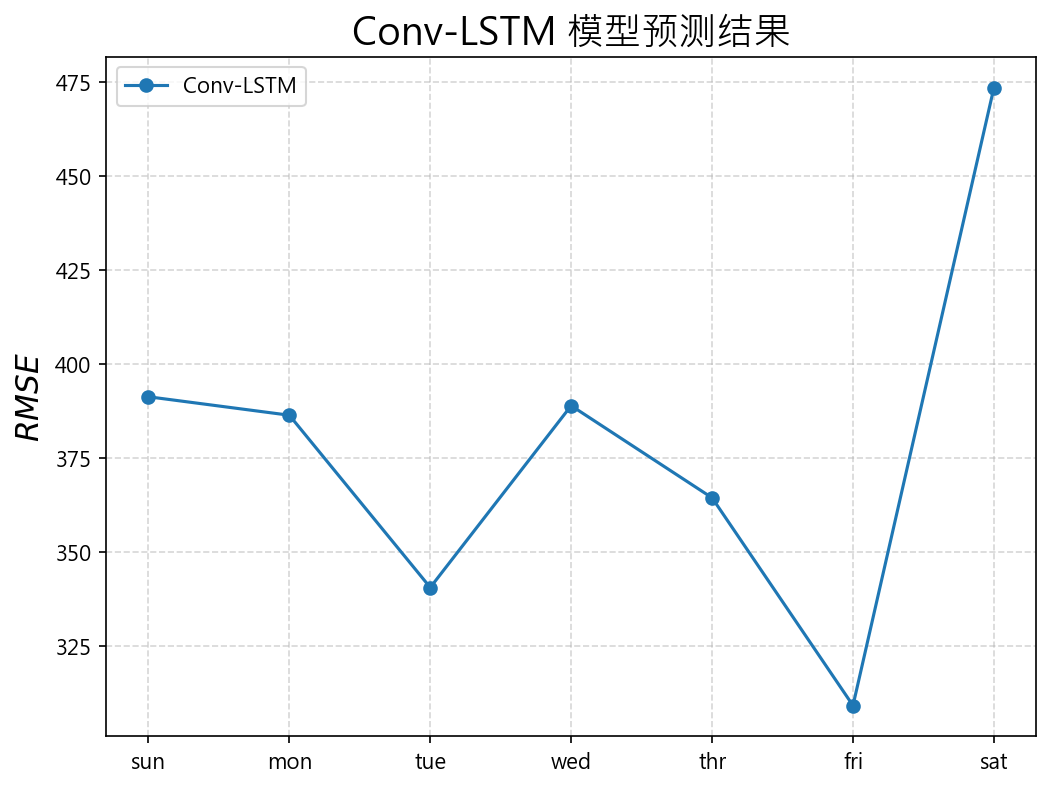

------头发不够，帽子来凑-----


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D


def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end, 0]
            train_seq = train_seq.reshape((len(train_seq), 1))
            X.append(train_seq)
            y.append(data[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

def conv_lstm_model(train, sw_width, n_steps, n_length, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 Encoder-Decoder LSTM 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu',
                         input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

def forecast(model, pred_seq, sw_width, n_length, n_steps):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width, n_length, n_steps):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width, n_length, n_steps) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('Conv-LSTM 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size, n_steps, n_length):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = conv_lstm_model(train, sw_width,  n_steps, n_length, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width, n_length, n_steps)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)
    
    print('------头发不够，帽子来凑-----')
    
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'Conv-LSTM'
    
    # 定义序列的数量和长度
    '''
    n_steps：子序列划分的数量，本例为2，将14天的数据划分为两个7的子序列；
    n_length：子序列每行的元素数，即列数。
    '''
    n_steps, n_length = 2, 7
    
    sliding_window_width= n_length * n_steps
    input_sequence_start=0
    
    epochs_num=20
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set, n_steps, n_length)